In [2]:
import os
import torch
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn

from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
# Global vars

SEED = 127
TRAIN_PATH = 'data/train'
TRAIN_BATCHSIZE = 32
EPOCHS = 3

# Data first look

In [4]:
# get labels

labels_list = []
train_imgs = os.listdir('data/train')

for f in train_imgs:
    
    # 0 for 'cat', 1 for 'dog'
    if f.split('.')[0] == 'cat':
        labels_list.append(0)

    elif f.split('.')[0] == 'dog':
        labels_list.append(1)

    else:
    # if no label 
        labels_list.append(-1)

print(f'Images count = {len(train_imgs)}\nLabels count = {len(labels_list)}')

Images count = 25000
Labels count = 25000


In [5]:
df_train = pd.DataFrame(columns= ['image', 'label'])
df_train['image'] = train_imgs
df_train['label'] = labels_list

df_train.head(3)

,image,label
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0


In [6]:
df_train['label'].unique()

array([0, 1], dtype=int64)

<Figure size 864x864 with 0 Axes>

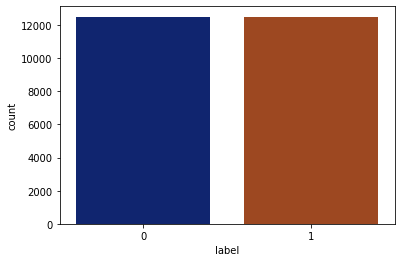

<Figure size 864x864 with 0 Axes>

In [7]:
sns.countplot(data= df_train, x= 'label', palette= 'dark')
plt.figure(figsize=(12,12))

In [11]:
shape_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])

    with Image.open(img_path) as img:
        width, height = img.size
        shape_arr.append((width, height))

np.unique(shape_arr, axis= 0).__len__()

KeyboardInterrupt: 

In [12]:
np.max(shape_arr, axis= 0)

array([500, 500])

In [13]:
np.min(shape_arr, axis= 0)

array([50, 49])

### *NOTE*: 8513 unique shapes of images, so reshape need.

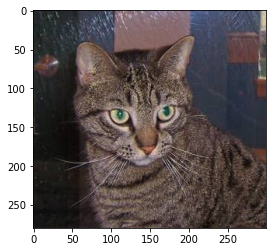

In [8]:
img_path = os.path.join(TRAIN_PATH, df_train['image'][1])

with Image.open(img_path) as img:
    plt.imshow(img)

# Mean and std to reshape and normalize

## Mean (channels)

In [20]:
r_mean_arr = []
g_mean_arr = []
b_mean_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_mean, g_mean, b_mean = np.mean(img_np, axis= (0,1))

        r_mean_arr.append(r_mean)
        g_mean_arr.append(g_mean)
        b_mean_arr.append(b_mean)


KeyboardInterrupt: 

In [ ]:
R_MEAN = np.mean(r_mean_arr) / 255
G_MEAN = np.mean(g_mean_arr) / 255
B_MEAN = np.mean(b_mean_arr) / 255

In [ ]:
print(f"Red ch mean   = {R_MEAN}\nGreen ch mean = {G_MEAN}\nBlue ch mean  = {B_MEAN}")

Red ch mean   = 0.48832284218884975
Green ch mean = 0.45508163042054794
Blue ch mean  = 0.4169560571643627


## Std (channels)

In [ ]:
r_std_arr = []
g_std_arr = []
b_std_arr = []

for i in range(0, df_train.shape[0]):
    img_path = os.path.join(TRAIN_PATH, df_train['image'][i])
    
    with Image.open(img_path) as img:
        img_np = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)

        r_std, g_std, b_std = np.std(img_np, axis= (0,1))

        r_std_arr.append(r_std)
        g_std_arr.append(g_std)
        b_std_arr.append(b_std)


In [ ]:
R_STD = np.mean(r_std_arr) / 255
G_STD = np.mean(g_std_arr) / 255
B_STD = np.mean(b_std_arr) / 255

In [ ]:
print(f"Red ch std   = {R_STD}\nGreen ch std = {G_STD}\nBlue ch std  = {B_STD}")

Red ch std   = 0.22944326551560382
Green ch std = 0.22498400642892036
Blue ch std  = 0.22518627654899104


# Train/test split and samples visual

In [9]:

X_train, X_test, y_train, y_test = train_test_split(df_train['image'], df_train['label'], test_size= 0.15, random_state= SEED, stratify= df_train['label'])

print(f'Train size = {X_train.shape[0]}\nTest size = {X_test.shape[0]}')

Train size = 21250
Test size = 3750


<AxesSubplot:xlabel='label', ylabel='count'>

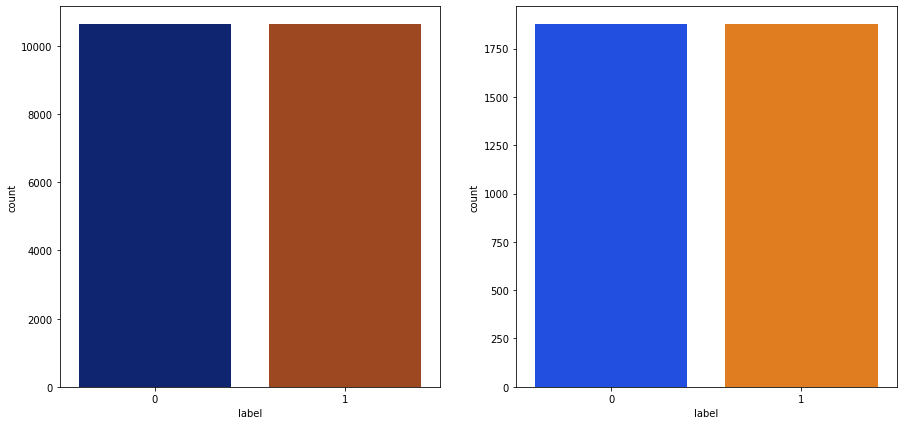

In [10]:
# stratified check

fig, axs = plt.subplots(1,2, figsize= (15,7))

sns.countplot(x= y_train, ax= axs[0], palette= 'dark')
sns.countplot(x= y_test, ax= axs[1], palette= 'bright')

# Transforms

In [14]:
train_transforms = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((64, 64)), 
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(), 
    #torchvision.transforms.Normalize([R_MEAN, G_MEAN, B_MEAN], [R_STD, G_STD, B_STD])])
    torchvision.transforms.Normalize(mean= [0.488, 0.455, 0.417], std= [0.229, 0.225, 0.225])])

In [16]:
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.ColorJitter(),
    torchvision.transforms.RandomCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Resize(128),
    torchvision.transforms.ToTensor()
])

# Creating train/test custom datasets and loader

In [17]:
from img_dataset_class import ImgsDataset
import img_dataset_class
import imp
imp.reload(img_dataset_class)

train_set = ImgsDataset(X_train, y_train, TRAIN_PATH, transforms_= data_transform)
test_set = ImgsDataset(X_test, y_test, TRAIN_PATH)

0 (3, 128, 128) 1
1 (3, 128, 128) 1
2 (3, 128, 128) 1
3 (3, 128, 128) 0


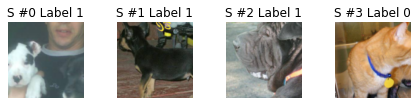

In [18]:
from torchvision import transforms

for i in range(len(train_set)):
    sample, label = train_set[i]

    print(i, sample.shape, label)

    
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()

    tr = transforms.ToPILImage()

    plt.imshow(tr(torch.Tensor(sample)))
    ax.set_title(f'S #{i} Label {label}')
    ax.axis('off')
    

    if i == 3:
        plt.show()
        break

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size= TRAIN_BATCHSIZE, shuffle=True, num_workers= 0)


In [20]:
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched[0].size(),
          sample_batched[1].size())
    
    if ((i_batch % 3 == 0) & (i_batch != 0)):
        break

0 torch.Size([32, 3, 128, 128]) torch.Size([32])
1 torch.Size([32, 3, 128, 128]) torch.Size([32])
2 torch.Size([32, 3, 128, 128]) torch.Size([32])
3 torch.Size([32, 3, 128, 128]) torch.Size([32])


# Implementing self-made CNN model

In [201]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # layer1
        self.cv1 = nn.Conv2d(in_channels= 3, out_channels= 10, kernel_size= 3)
        #self.batch_norm1 = nn.BatchNorm2d(num_features= 10)
        self.relu1 = nn.ReLU()

        # layer2
        self.cv2 = nn.Conv2d(in_channels= 10, out_channels= 15, kernel_size= 3)
        #self.batch_norm2 = nn.BatchNorm2d(num_features= 15)
        self.relu2 = nn.ReLU()


        # layer3
        self.cv3 = nn.Conv2d(in_channels= 15, out_channels= 20, kernel_size= 3)
        #self.batch_norm3 = nn.BatchNorm2d(num_features= 20)
        self.relu3 = nn.ReLU()

        # fc1
        self.fc1 = nn.Linear(67280, 100)
        self.relu_fc1 = nn.ReLU()

        # fc1
        self.fc2 = nn.Linear(100, 50)
        self.relu_fc2 = nn.ReLU()

        # fc1
        self.fc3 = nn.Linear(50, 2)
        
        #self.log_softmax = nn.Softmax(dim= 1)
        #self.sigm3 = nn.Sigmoid()


    def forward(self, x):
        ## l1
        #x = self.relu1(self.batch_norm1(self.cv1(x)))
#
        ## l2
        #x = self.relu2(self.batch_norm2(self.cv2(x)))
#
        ## l3
        #x = self.relu3(self.batch_norm3(self.cv3(x)))
#
        #x = x.view(x.size(0), -1)


        # l1
        x = self.relu1(self.cv1(x))

        # l2
        x = self.relu2(self.cv2(x))

        # l3
        x = self.relu3(self.cv3(x))

        x = x.view(x.size(0), -1)



        # fc 1,2,3
        x = self.relu_fc1(self.fc1(x))
        x = self.relu_fc2(self.fc2(x))

        x = self.fc3(x)
        
        #x = self.sigm3(x)
        #x = self.log_softmax(self.fc3(x))

        return x

net = ConvNet()
print(net)
        



ConvNet(
  (cv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (cv2): Conv2d(10, 15, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (cv3): Conv2d(15, 20, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (fc1): Linear(in_features=67280, out_features=100, bias=True)
  (relu_fc1): ReLU()
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (relu_fc2): ReLU()
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [21]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.007)
criterion = nn.CrossEntropyLoss()

NameError: name 'net' is not defined

In [260]:
for epoch in range(EPOCHS):  

    running_loss = 0.0
    for batch_no, data in enumerate(train_loader, 0):
        
        inps, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        #print(type(data['image']))
        #print(data['label'])

        #labels = data['label'].view(data['label'].shape[0], -1)
        #labels = labels.float()


        # forward + backward + optimize
        outputs = net(inps)

        #print(outputs.shape)
        #print(labels.shape)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()


        # print statistics
        running_loss += loss.item()
        if batch_no % 200 == 0:    # print every 10 mini-batches
            print(f'[epoch {epoch + 1}, batch# {batch_no + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x297680 and 67280x100)

# Transfer learning attemp

In [28]:
model = torchvision.models.densenet121(pretrained=True)

In [29]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [30]:
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 500),
    nn.Linear(500, 2)
)


[Epoch 1/3] Iteration 10 -> Train Loss: 0.7609, Accuracy: 0.594
[Epoch 1/3] Iteration 20 -> Train Loss: 0.6910, Accuracy: 0.438
[Epoch 1/3] Iteration 30 -> Train Loss: 0.6731, Accuracy: 0.531
[Epoch 1/3] Iteration 40 -> Train Loss: 0.7019, Accuracy: 0.625
[Epoch 1/3] Iteration 50 -> Train Loss: 0.6771, Accuracy: 0.438
[Epoch 1/3] Iteration 60 -> Train Loss: 0.6869, Accuracy: 0.562
[Epoch 1/3] Iteration 70 -> Train Loss: 0.6954, Accuracy: 0.469
[Epoch 1/3] Iteration 80 -> Train Loss: 0.6653, Accuracy: 0.594
[Epoch 1/3] Iteration 90 -> Train Loss: 0.6785, Accuracy: 0.750
[Epoch 1/3] Iteration 100 -> Train Loss: 0.6793, Accuracy: 0.781
[Epoch 1/3] Iteration 110 -> Train Loss: 0.6613, Accuracy: 0.625
[Epoch 1/3] Iteration 120 -> Train Loss: 0.6464, Accuracy: 0.594
[Epoch 1/3] Iteration 130 -> Train Loss: 0.6341, Accuracy: 0.656
[Epoch 1/3] Iteration 140 -> Train Loss: 0.6486, Accuracy: 0.688
[Epoch 1/3] Iteration 150 -> Train Loss: 0.6089, Accuracy: 0.531
[Epoch 1/3] Iteration 160 -> Train

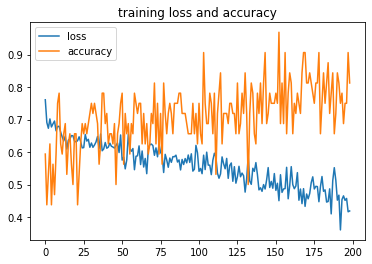

In [31]:
torch.manual_seed(SEED)

itr = 1
p_itr = 10
model.train()
total_loss = 0
loss_list = []
acc_list = []
for epoch in range(EPOCHS):
    for batch_no, data in enumerate(train_loader, 0):
        
        samples, labels = data

        optimizer.zero_grad()

        output = model(samples)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        if itr%p_itr == 0:
            pred = torch.argmax(output, dim=1)
            correct = pred.eq(labels)
            acc = torch.mean(correct.float())
            print('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Accuracy: {:.3f}'.format(epoch+1, EPOCHS, itr, total_loss/p_itr, acc))
            loss_list.append(total_loss/p_itr)
            acc_list.append(acc)
            total_loss = 0
            
        itr += 1

plt.plot(loss_list, label='loss')
plt.plot(acc_list, label='accuracy')
plt.legend()
plt.title('training loss and accuracy')
plt.show()